In [1]:
%load_ext lab_black

In [2]:
%matplotlib widget

# TODOs

## Moving:
- Move queue
    - A* pathfinding with weights based on move_cost
    - Add high cost where another bot will collide 
        - But position of other bots changes ... 
        - Maybe first just increase cose of entire path?
        - Can bots switch position?
        - Maybe A*, evaluate collisions, if collision, add cost to collision point and repeat until max repeats
        - Cost of collision decrease with distance (i.e. things more likely to change in future anyway)
            - Still want fairly high cost since better not to change work queue
 
- Avoid collisions
    - Record trajectory of all units
        - Keep light/heavy enemy/friendly separate (heavies should only avoid heavies for example)
        - If mining add X turns at that location
    - Ensure no collisions within X turns, otherwise change route
    

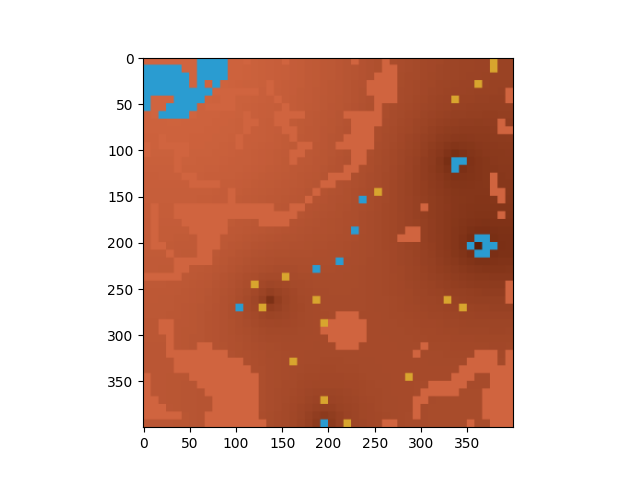

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from luxai_s2 import LuxAI_S2
from util import game_state_from_env, show_env
from util import UP, DOWN, LEFT, RIGHT, CENTER, ICE, ORE, METAL, POWER, WATER
from util import path_to_actions, actions_to_path


# env = get_test_env()
env = LuxAI_S2()
# obs = env.reset(seed=42)
obs = env.reset(seed=178220973)

game_state = game_state_from_env(env)
rend = env.render("rgb_array")
# plt.imshow(
#     np.transpose(rend, axes=[1, 0, 2])
# )  # Game state stores transposed, so for comparison sake, plot transposed
plt.imshow(
    rend
)  # Game state stores transposed, so for comparison sake, plot transposed

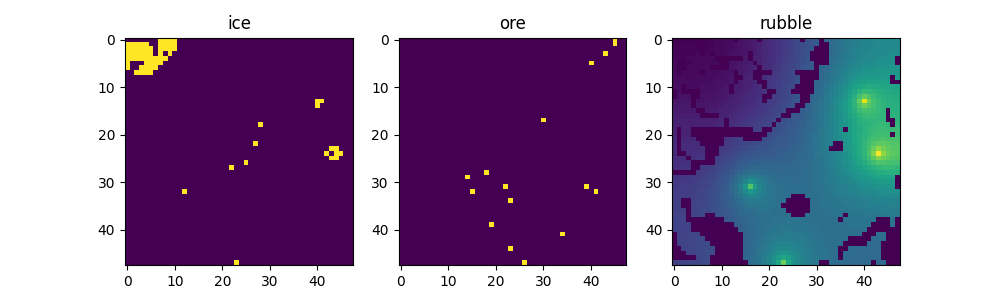

In [5]:
import matplotlib.pyplot as plt


def make_maps(game_state):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].imshow(game_state.board.ice.T)
    axs[1].imshow(game_state.board.ore.T)
    axs[2].imshow(game_state.board.rubble.T)
    axs[0].set_title("ice")
    axs[1].set_title("ore")
    axs[2].set_title("rubble")
    return fig, axs


fig, axs = make_maps(game_state)
# game_state.units["player_0"]["unit_5"]

In [6]:
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder

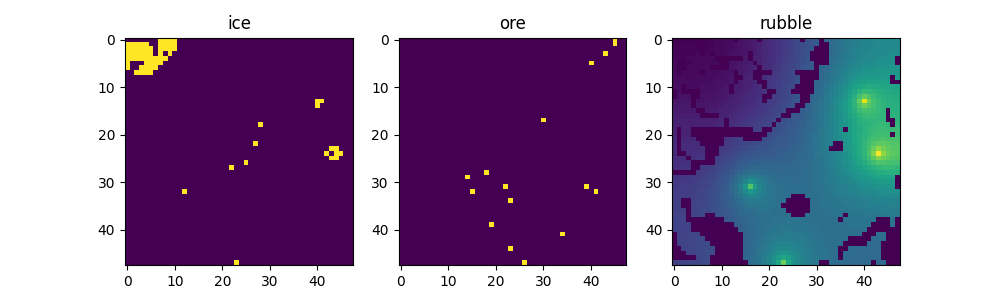

In [20]:
fig, axs = make_maps(game_state)

In [22]:
rubble = game_state.board.rubble.copy()
start = [45, 8]
end = [30, 20]

matrix_map = rubble.T.copy()
# matrix_map = np.moveaxis(rubble.copy(), (0, 1), (1, 0))
matrix_map += 10

grid = Grid(matrix=matrix_map)

start_ = grid.node(*start)
end_ = grid.node(*end)

finder = AStarFinder()
path, runs = finder.find_path(start_, end_, grid)
path = np.array(path)

In [23]:
for ax in axs:
    ax.scatter(path[:, 0], path[:, 1], marker="+", s=10, c="r")

In [14]:
from path_finder import PathFinder

start = [0, 0]
end = [45, 45]
cost_map = game_state.board.rubble.T.copy() + 10


path_finder = PathFinder()
path = path_finder.path(start, end, rubble=rubble)

In [15]:
def add_path(axs, path, **kwargs):
    c = kwargs.pop("c", "white")
    for ax in axs:
        ax.scatter(path[:, 0], path[:, 1], marker="+", s=10, c=c, **kwargs)


add_path(axs, path)
fig.show()

## Faster Pathing

Only path in a small area around start/end coordinates

In [119]:
plt.close()

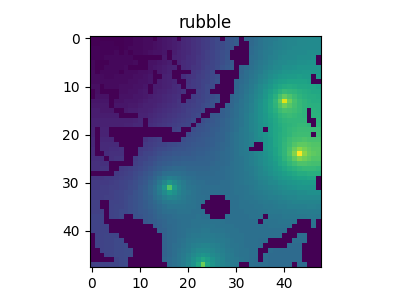

In [120]:
import matplotlib.patches as patches


def make_small_map(rubble):
    fig, axs = plt.subplots(1, 1, figsize=(4, 3))
    axs = [axs]
    axs[0].imshow(rubble.T)
    # axs[1].imshow(game_state.board.ore.T)
    # axs[2].imshow(game_state.board.rubble.T)
    axs[0].set_title("rubble")
    return fig, axs


def add_rectangle(ax, start, end, **kwargs):
    x1, y1 = start
    x2, y2 = end
    width = x2 - x1
    height = y2 - y1
    rect = patches.Rectangle(
        (x1, y1),
        width,
        height,
        linestyle="dashed",
        facecolor="none",
        linewidth=2,
        edgecolor="r",
        **kwargs
    )
    ax.add_patch(rect)

    ax.plot(x1, y1, "rx", markersize=10)
    ax.plot(x2, y2, "yx", markersize=10)


fig, axs = make_small_map(rubble)

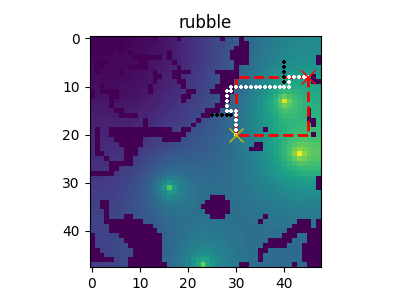

In [134]:
rubble = game_state.board.rubble.copy()

start = [45, 8]
end = [30, 20]
margin = 2
additional_blocked_cells = np.array(
    [[40, 5 + i] for i in range(5)] + [[25 + i, 16] for i in range(5)]
)
# additional_blocked_cells = None

fig, axs = make_small_map(rubble)
add_rectangle(axs[0], start, end)
if additional_blocked_cells is not None:
    add_path(axs, additional_blocked_cells, c="black")

#################################


cost_map = rubble.copy()
cost_map += 10

if additional_blocked_cells is not None:
    for x, y in additional_blocked_cells:
        # cost_map[y, x] = -1
        cost_map[x, y] = -1


coords = np.array([start, end])

# x, y
mins = np.min(coords, axis=0)
maxs = np.max(coords, axis=0)

# x, y
lowers = [max(0, v - margin) for v in mins]
uppers = [
    min(s - 1, v + margin) + 1 for s, v in zip(reversed(cost_map.shape), maxs)
]  # +1 for range

x_range, y_range = [(lowers[i], uppers[i]) for i in range(2)]

# x, y
new_cost = cost_map[range(*x_range), :][:, range(*y_range)]
new_cost_t = new_cost.T  # Pathfinder requires transposed map

# Make small grid and set start/end
grid = Grid(matrix=new_cost_t)
grid_start = grid.node(*[c - l for c, l in zip(start, lowers)])
grid_end = grid.node(*[c - l for c, l in zip(end, lowers)])

# Find Path
pathfinder = AStarFinder(diagonal_movement=-1)
path, runs = pathfinder.find_path(grid_start, grid_end, grid)

# Readjust for original map
if len(path) > 0:
    path = np.array(path, dtype=int) + np.array(lowers, dtype=int)

add_path(axs, path)

(<Figure size 400x300 with 1 Axes>,
 [<AxesSubplot: title={'center': 'rubble'}>])

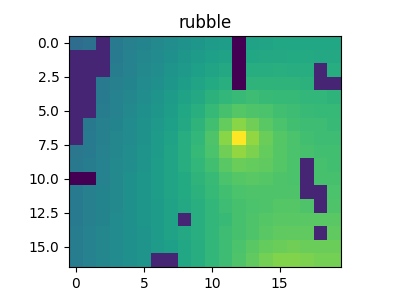

In [135]:
make_small_map(new_cost)

In [136]:
raise NotImplementedError('below here I have not updated for agent5')

NotImplementedError: below here I have not updated for agent5

## Figure out how to avoid collisions

In [12]:
game_state.units["player_0"].keys()

dict_keys(['unit_4', 'unit_5'])

player_0 unit_4 -- Pos: [25 34]
player_0 unit_5 -- Pos: [26 33]


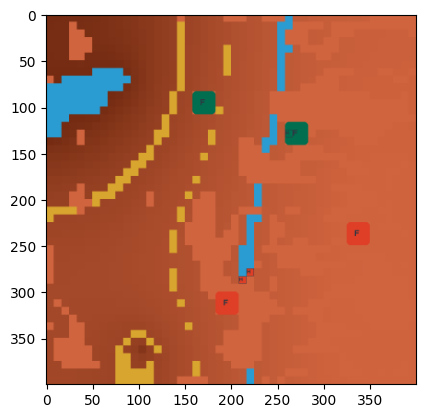

In [13]:
env = get_test_env()

rgb_array = env.render("rgb_array")
plt.imshow(rgb_array)


# env.render('rgb_array')
def _units(env):
    game_state = game_state_from_env(env)
    units = [game_state.units["player_0"][k] for k in ["unit_4", "unit_5"]]
    return units


units = _units(env)
for unit in units:
    print(f"{unit.agent_id} {unit.unit_id} -- Pos: {unit.pos}")

### Let's see if bots can switch positions

In [14]:
env = get_test_env()
game_state = game_state_from_env(env)

units = _units(env)
u4 = units[0]
u5 = units[1]

# First get the two units next to each other
actions = {
    "player_0": {
        u5.unit_id: [u5.move(DOWN)],
    },
    "player_1": {},
}

obs, rews, dones, infos = env.step(actions)
_ = show_env(env)

In [15]:
# Store up some energy
for i in range(5):
    actions = {
        "player_0": {},
        "player_1": {},
    }
    obs, rews, dones, infos = env.step(actions)

# Now try switch their positions
units = _units(env)
for unit in units:
    print(f"{unit.agent_id} {unit.unit_id} -- Pos: {unit.pos}")
actions = {
    "player_0": {
        u4.unit_id: [u4.move(RIGHT)],
        u5.unit_id: [u5.move(LEFT)],
    },
    "player_1": {},
}

obs, rews, dones, infos = env.step(actions)
_ = show_env(env)

units = _units(env)
for unit in units:
    print(f"{unit.agent_id} {unit.unit_id} -- Pos: {unit.pos}")

player_0 unit_4 -- Pos: [25 34]
player_0 unit_5 -- Pos: [26 34]
player_0 unit_4 -- Pos: [26 34]
player_0 unit_5 -- Pos: [25 34]


**Success -- Units switched position**

### Test giving path of actions to unit
- Assuming unit has enough energy for all actions
- Assuming no collisions

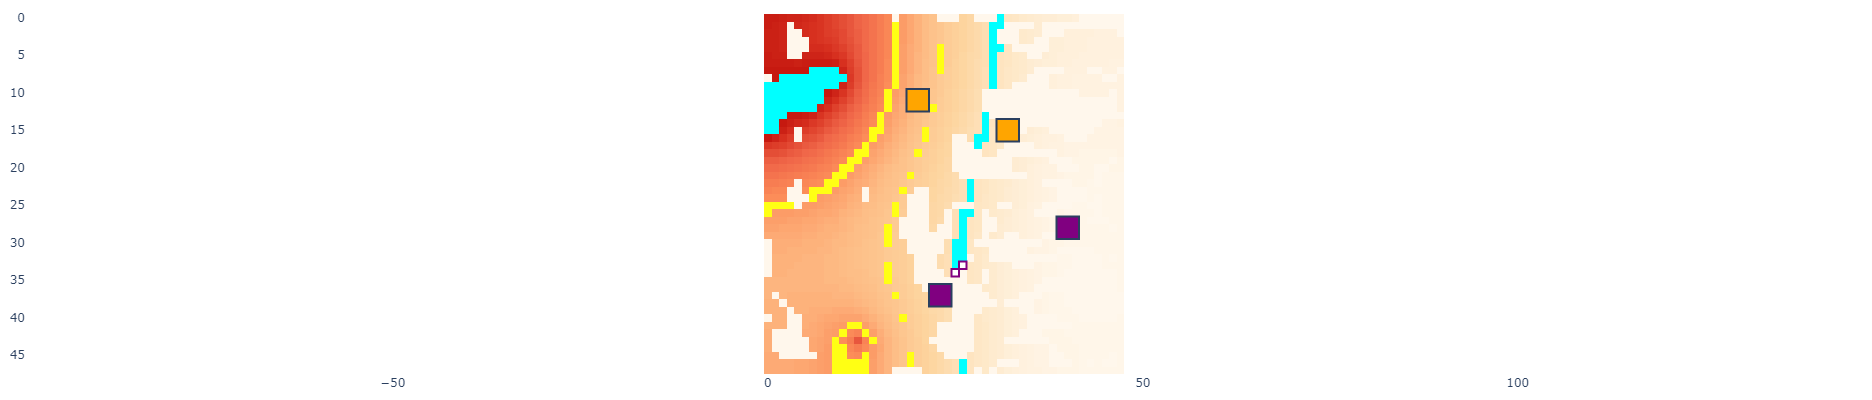

In [69]:
from matplotlib import colors
from lux.kit import GameState
from luxai2022.unit import UnitType
import plotly.graph_objects as go
import re
from matplotlib.patches import Rectangle

from util import show_env, mpl_plot_path, plotly_plot_path
import util

env = get_test_env()
game_state = game_state_from_env(env)
units = _units(env)
unit = units[0]

fig = show_env(env, mode="plotly")
fig.show()

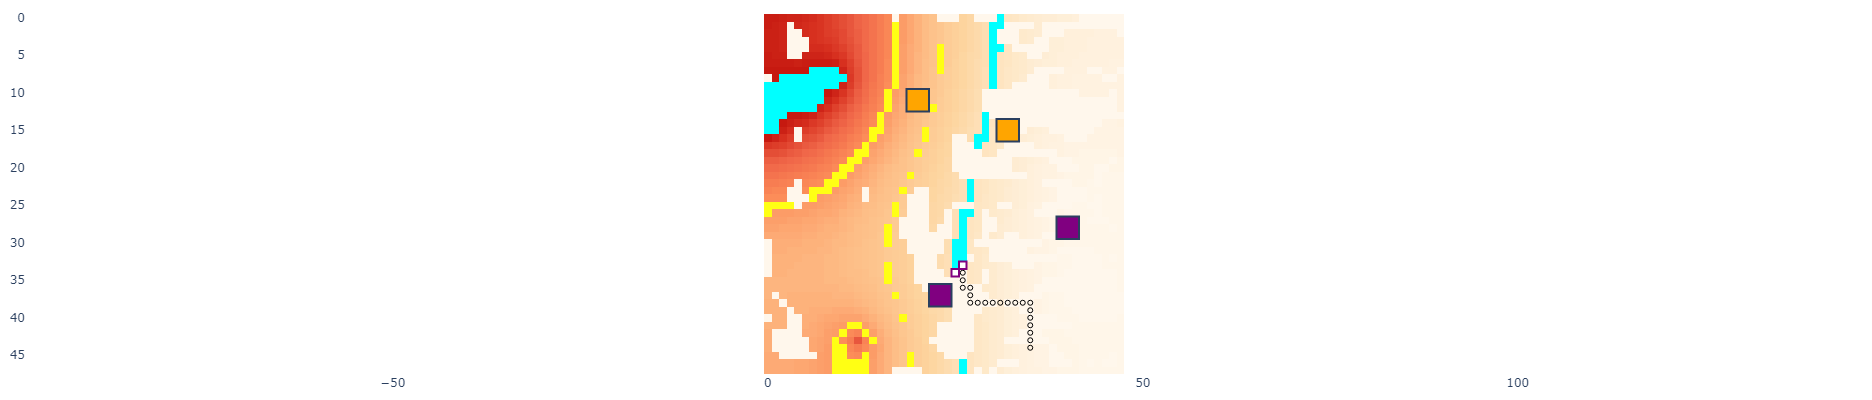

In [70]:
# Cost map for heavy units
cost_map = game_state.board.rubble.T.copy() + 10

pf = PathFinder(cost_map)
path = pf.path(unit.pos, [p + 10 for p in unit.pos])
fig = show_env(env)

plotly_plot_path(fig, path)

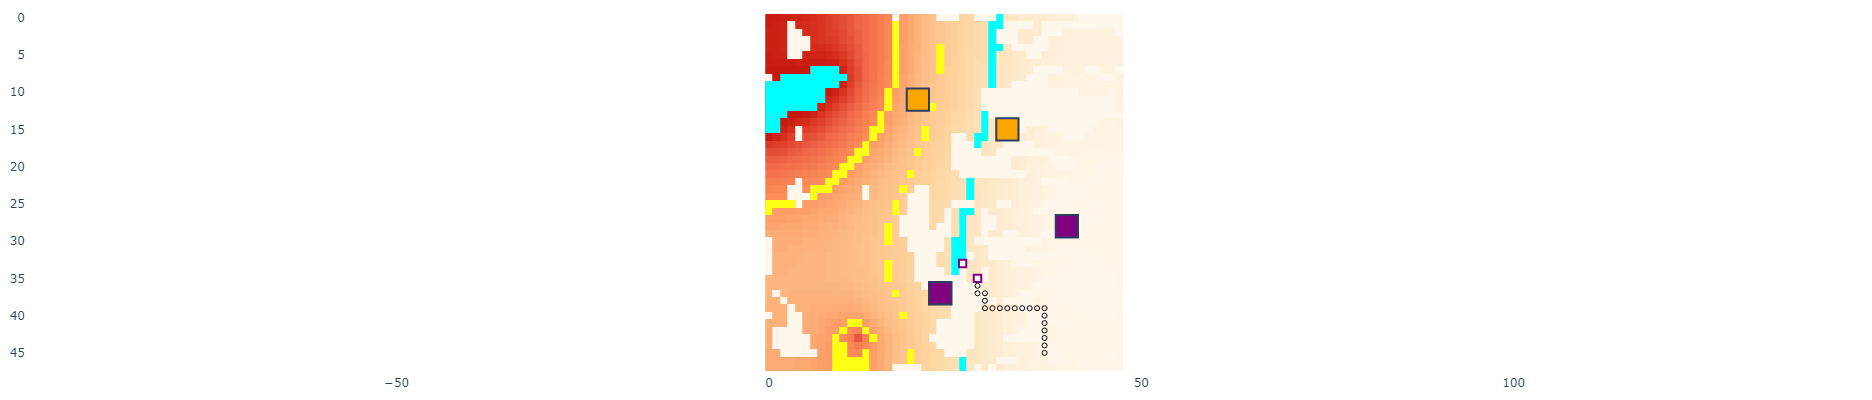

In [74]:
actions = {
    "player_0": {
        unit.unit_id: path_to_actions(unit, path),
    },
    "player_1": {},
}

obs, rews, dones, infos = env.step(actions)
fig = show_env(env)
fig

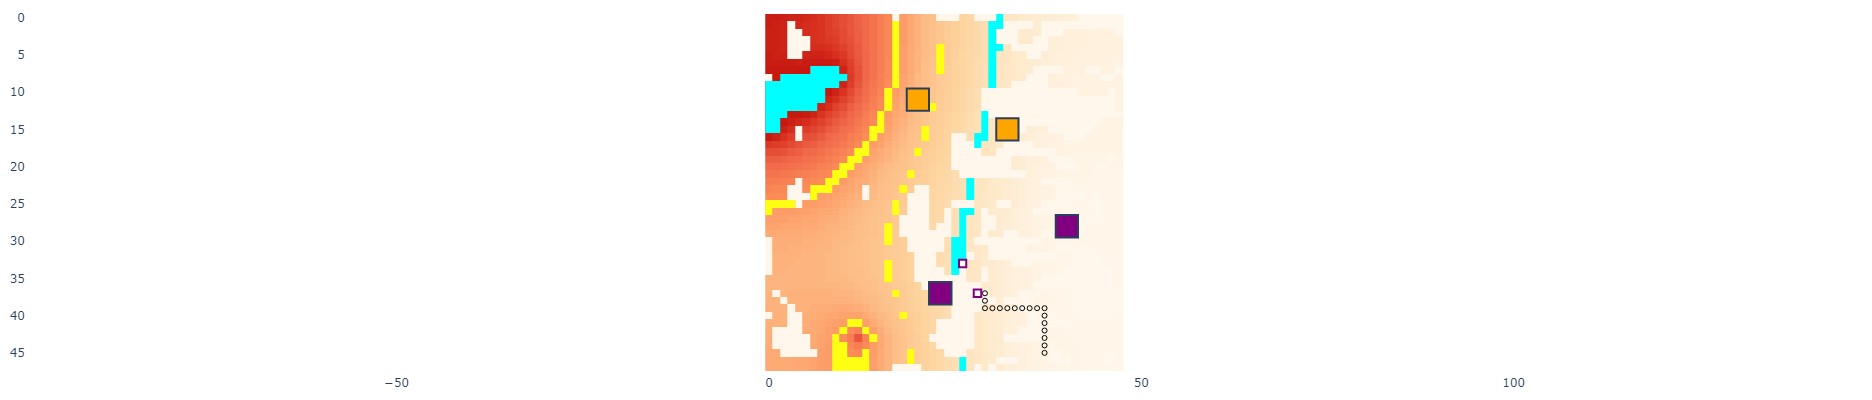

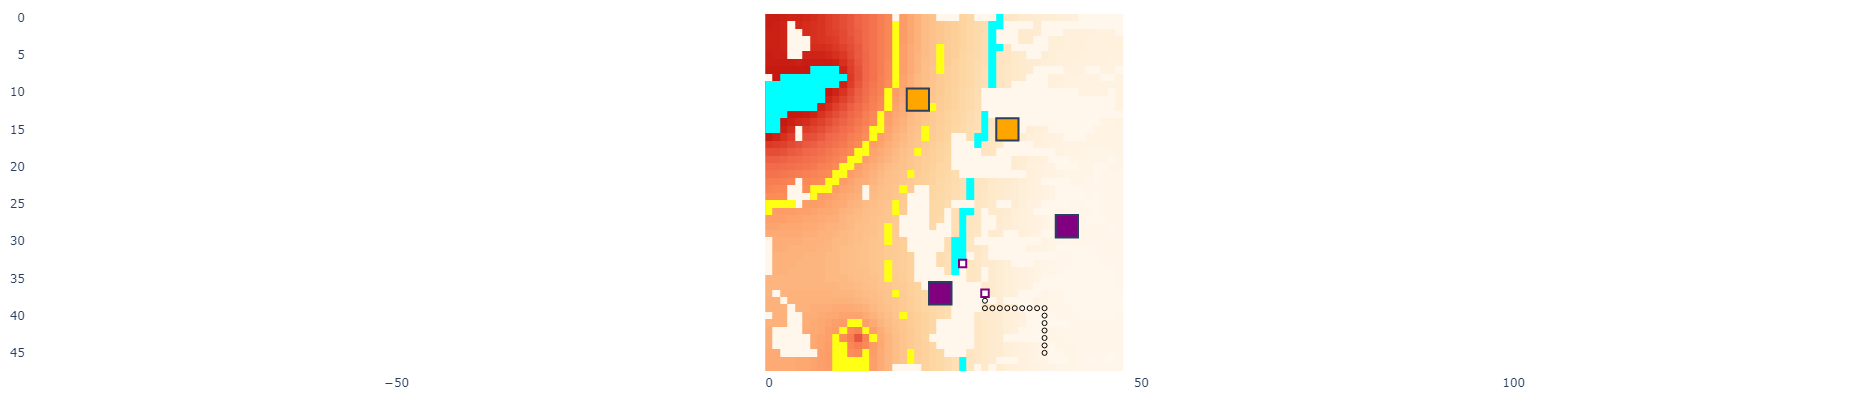

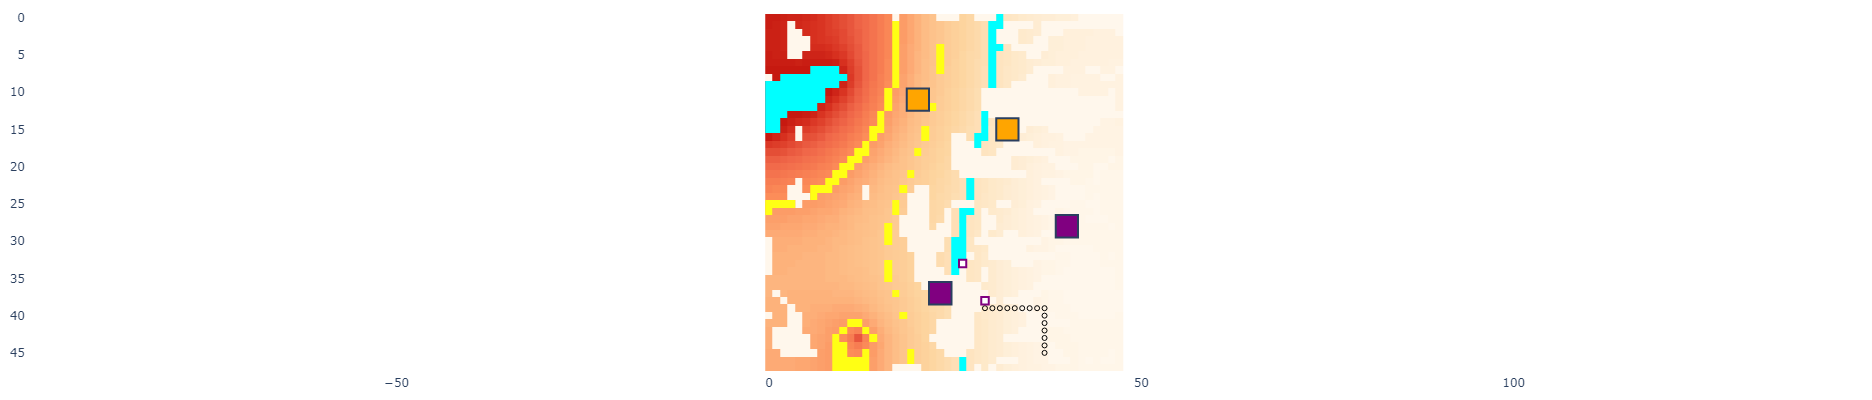

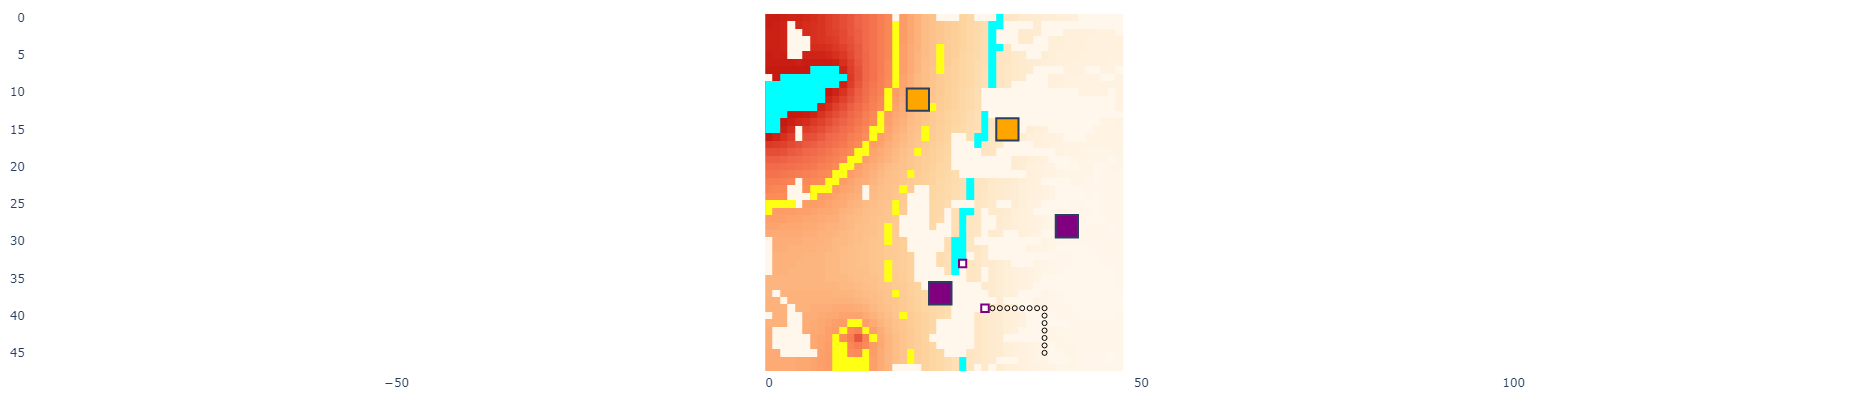

In [76]:
actions = {
    "player_0": {},
    "player_1": {},
}

figs = []
for i in range(4):
    obs, rews, dones, infos = env.step(actions)
    figs.append(show_env(env))
for fig in figs:
    fig.show()